In [1]:
#import useful files
import statistics as stat
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#file path with glob
path = "Tektronix_data/"
all_files = glob.glob(path + "*.csv")

In [3]:
#turn all 512 files into lists
var = [pd.read_csv(filename,index_col=None,header=0,skiprows=17) for filename in all_files]

In [4]:
#concat all lists and turn into 1 big dataframe
dataframe = pd.concat(var,axis=0,ignore_index=True)

In [5]:
#renaming the headers (they came as Channel 1,2,3,4 - need to know what they represent)
rename = ['Time','Excitation_Pulse','Raman_Channel_Detection_640nm','Raman_Channel_Detection_660nm','Green_Return_532nm']
dataframe.columns = rename

In [6]:
dataframe.head()

,Time,Excitation_Pulse,Raman_Channel_Detection_640nm,Raman_Channel_Detection_660nm,Green_Return_532nm
0,-9.430000e-08,-0.004,0.002,-4.000000e-03,0.008
1,-9.410000e-08,-0.004,-0.002,4.440890e-17,0.008
2,-9.390000e-08,-0.004,-0.010,-8.000000e-03,0.004
3,-9.370000e-08,-0.012,-0.002,-8.000000e-03,0.008
4,-9.350000e-08,-0.004,-0.010,-4.000000e-03,0.008


In [7]:
#change the data type
Clean_dataframe = dataframe.astype(float)

In [8]:
uniform_dataframe=Clean_dataframe.assign(Time = Clean_dataframe['Time']*1e9)

In [9]:
#Setting the Time as the index column
uniform_dataframe.set_index("Time",drop=True,inplace=True)

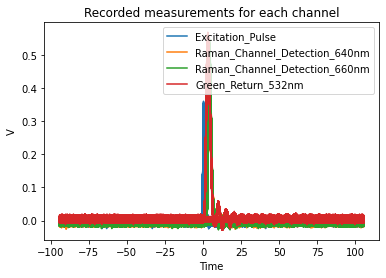

In [10]:
#Plot all columns against Time
plot_columns = ['Excitation_Pulse','Raman_Channel_Detection_640nm','Raman_Channel_Detection_660nm','Green_Return_532nm']
uniform_dataframe[plot_columns].plot()

plt.xlabel('Time')
plt.ylabel('V')
plt.title('Recorded measurements for each channel')
plt.show()

### Calculating averages and SD's

In [11]:
#Split the large dataframe into 512 smaller dataframes
def split_dataframe_by_position(df, splits):
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for split in range(splits):
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes
split_dataframes = split_dataframe_by_position(uniform_dataframe, 512)
#Test if our split is working
print('Quick test, the max value of the last dataframe = ',split_dataframes[511].Excitation_Pulse.max(),'V')

Quick test, the max value of the last dataframe =  0.34 V


In [12]:
#Create code that returns the FWHM value and its 2 locations (time duration)
def FWHM_time_duration(X,Y):
    half_max = max(Y) / 2.
    #find the full width at half maxima, we choose denominator to be 2
    #if we want full width at tenth maxima, we choose it to be 10 
    frac = 2
    d = Y - (max(Y) / frac) 
    #locate and subtract the 2 points in x axis (which is difference in time) for FWHM duration
    indexes = np.where(d > 0)[0]
    return abs(X[indexes[-1]] - X[indexes[0]])

def FWHM_value(Y):
    FWHM = max(Y)/2
    return FWHM

### Results for Excitation Pulse

In [13]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_ExcitationPulse = []
localMaxVoltageTime_ExcitationPulse = []
pulseDurations_ExcitationPulse = []
FWHM_values_ExcitationPulse = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_ExcitationPulse.append(split_dataframes[i].Excitation_Pulse.max())
    localMaxVoltageTime_ExcitationPulse.append(split_dataframes[i].Excitation_Pulse.idxmax())
    pulseDurations_ExcitationPulse.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Excitation_Pulse))
    FWHM_values_ExcitationPulse.append(FWHM_value(split_dataframes[i].Excitation_Pulse))

In [14]:
print('Average maximum of the pulse for Excitation Pulse = {0} V'.format(np.average(localMaxVoltage_ExcitationPulse)))
print('Average time of occurance of the max pulse for Excitation Pulse = {0} ns'.format(np.average(localMaxVoltageTime_ExcitationPulse)))
print('Average pulse duration for Excitation Pulse = {0} ns'.format(np.average(pulseDurations_ExcitationPulse)))
print('Average value for the FWHM for Excitation Pulse = {0} V'.format(np.average(FWHM_values_ExcitationPulse)))

Average maximum of the pulse for Excitation Pulse = 0.331945205479452 V
Average time of occurance of the max pulse for Excitation Pulse = 0.285518590998043 ns
Average pulse duration for Excitation Pulse = 0.5350293542074364 ns
Average value for the FWHM for Excitation Pulse = 0.165972602739726 V


In [15]:
print('Standard deviation for the maximum of the pulse for Excitation Pulse = {0} V'.format(np.std(localMaxVoltage_ExcitationPulse)))
print('Standard deviation for time of occurance of the max pulse for Excitation Pulse = {0} ns'.format(np.std(localMaxVoltageTime_ExcitationPulse)))
print('Standard deviation of pulse duration for Excitation Pulse = {0} ns'.format(np.std(pulseDurations_ExcitationPulse)))
print('Standard deviation of value for the FWHM for Excitation Pulse = {0} V'.format(np.std(FWHM_values_ExcitationPulse)))

Standard deviation for the maximum of the pulse for Excitation Pulse = 0.009165414630510044 V
Standard deviation for time of occurance of the max pulse for Excitation Pulse = 0.05618040505987667 ns
Standard deviation of pulse duration for Excitation Pulse = 0.09366399705228234 ns
Standard deviation of value for the FWHM for Excitation Pulse = 0.004582707315255022 V


### Results for Green Return

In [16]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_greenReturn = []
localMaxVoltageTime_greenReturn = []
pulseDurations_greenReturn = []
FWHM_values_greenReturn = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_greenReturn.append(split_dataframes[i].Green_Return_532nm.max())
    localMaxVoltageTime_greenReturn.append(split_dataframes[i].Green_Return_532nm.idxmax())
    pulseDurations_greenReturn.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Green_Return_532nm))
    FWHM_values_greenReturn.append(FWHM_value(split_dataframes[i].Green_Return_532nm))

In [17]:
print('Average maximum of the pulse for Green Return 532nm = {0} V'.format(np.average(localMaxVoltage_greenReturn)))
print('Average time of occurance of the max pulse for Green Return 532nm = {0} ns'.format(np.average(localMaxVoltageTime_greenReturn)))
print('Average pulse duration for Green Return 532nm = {0} ns'.format(np.average(pulseDurations_greenReturn)))
print('Average value for the FWHM for Green Return 532nm = {0} V'.format(np.average(FWHM_values_greenReturn)))

Average maximum of the pulse for Green Return 532nm = 0.5541213307240704 V
Average time of occurance of the max pulse for Green Return 532nm = 3.140704500978474 ns
Average pulse duration for Green Return 532nm = 2.6931506849315068 ns
Average value for the FWHM for Green Return 532nm = 0.2770606653620352 V


In [18]:
print('Standard deviation for the maximum of the pulse for Green Return 532nm = {0} V'.format(np.std(localMaxVoltage_greenReturn)))
print('Standard deviation for time of occurance of the max pulse for Green Return 532nm = {0} ns'.format(np.std(localMaxVoltageTime_greenReturn)))
print('Standard deviation of pulse duration for Green Return 532nm = {0} ns'.format(np.std(pulseDurations_greenReturn)))
print('Standard deviation of value for the FWHM for Green Return 532nm = {0} V'.format(np.std(FWHM_values_greenReturn)))

Standard deviation for the maximum of the pulse for Green Return 532nm = 0.004124405310891265 V
Standard deviation for time of occurance of the max pulse for Green Return 532nm = 0.10720927446634602 ns
Standard deviation of pulse duration for Green Return 532nm = 0.09976515866319512 ns
Standard deviation of value for the FWHM for Green Return 532nm = 0.0020622026554456326 V


### Results for Raman Channel 660nm

In [19]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_ramanChannel660nm = []
localMaxVoltageTime_ramanChannel660nm = []
pulseDurations_ramanChannel660nm = []
FWHM_values_ramanChannel660nm = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_ramanChannel660nm.append(split_dataframes[i].Raman_Channel_Detection_660nm.max())
    localMaxVoltageTime_ramanChannel660nm.append(split_dataframes[i].Raman_Channel_Detection_660nm.idxmax())
    pulseDurations_ramanChannel660nm.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Raman_Channel_Detection_660nm))
    FWHM_values_ramanChannel660nm.append(FWHM_value(split_dataframes[i].Raman_Channel_Detection_660nm))

In [20]:
print('Average maximum of the pulse for Raman Channel 660nm = {0} V'.format(np.average(localMaxVoltage_ramanChannel660nm)))
print('Average time of occurance of the max pulse for Raman Channel 660nm = {0} ns'.format(np.average(localMaxVoltageTime_ramanChannel660nm)))
print('Average pulse duration for Raman Channel 660nm = {0} ns'.format(np.average(pulseDurations_ramanChannel660nm)))
print('Average value for the FWHM for Raman Channel 660nm = {0} V'.format(np.average(FWHM_values_ramanChannel660nm)))

Average maximum of the pulse for Raman Channel 660nm = 0.49683757338551854 V
Average time of occurance of the max pulse for Raman Channel 660nm = 4.247162426614482 ns
Average pulse duration for Raman Channel 660nm = 1.9589041095890414 ns
Average value for the FWHM for Raman Channel 660nm = 0.24841878669275927 V


In [21]:
print('Standard deviation for the maximum of the pulse for Raman Channel 660nm = {0} V'.format(np.std(localMaxVoltage_ramanChannel660nm)))
print('Standard deviation for time of occurance of the max pulse for Raman Channel 660nm = {0} ns'.format(np.std(localMaxVoltageTime_ramanChannel660nm)))
print('Standard deviation of pulse duration for Raman Channel 660nm = {0} ns'.format(np.std(pulseDurations_ramanChannel660nm)))
print('Standard deviation of value for the FWHM for Raman Channel 660nm = {0} V'.format(np.std(FWHM_values_ramanChannel660nm)))

Standard deviation for the maximum of the pulse for Raman Channel 660nm = 0.014262394176771893 V
Standard deviation for time of occurance of the max pulse for Raman Channel 660nm = 0.09745675460823133 ns
Standard deviation of pulse duration for Raman Channel 660nm = 0.08732809561922845 ns
Standard deviation of value for the FWHM for Raman Channel 660nm = 0.007131197088385947 V


### Results for Raman Channel 640nm

In [22]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_ramanChannel640nm = []
localMaxVoltageTime_ramanChannel640nm = []
pulseDurations_ramanChannel640nm = []
FWHM_values_ramanChannel640nm = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_ramanChannel640nm.append(split_dataframes[i].Raman_Channel_Detection_640nm.max())
    localMaxVoltageTime_ramanChannel640nm.append(split_dataframes[i].Raman_Channel_Detection_640nm.idxmax())
    pulseDurations_ramanChannel640nm.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Raman_Channel_Detection_640nm))
    FWHM_values_ramanChannel640nm.append(FWHM_value(split_dataframes[i].Raman_Channel_Detection_640nm))

In [23]:
print('Average maximum of the pulse for Raman Channel 640nm = {0} V'.format(np.average(localMaxVoltage_ramanChannel640nm)))
print('Average time of occurance of the max pulse for Raman Channel 640nm = {0} ns'.format(np.average(localMaxVoltageTime_ramanChannel640nm)))
print('Average pulse duration for Raman Channel 640nm = {0} ns'.format(np.average(pulseDurations_ramanChannel640nm)))
print('Average value for the FWHM for Raman Channel 640nm = {0} V'.format(np.average(FWHM_values_ramanChannel640nm)))

Average maximum of the pulse for Raman Channel 640nm = 0.40228962818003916 V
Average time of occurance of the max pulse for Raman Channel 640nm = 4.286301369863013 ns
Average pulse duration for Raman Channel 640nm = 2.108023483365949 ns
Average value for the FWHM for Raman Channel 640nm = 0.20114481409001958 V


In [24]:
print('Standard deviation for the maximum of the pulse for Raman Channel 640nm = {0} V'.format(np.std(localMaxVoltage_ramanChannel640nm)))
print('Standard deviation for time of occurance of the max pulse for Raman Channel 640nm = {0} ns'.format(np.std(localMaxVoltageTime_ramanChannel640nm)))
print('Standard deviation of pulse duration for Raman Channel 640nm = {0} ns'.format(np.std(pulseDurations_ramanChannel640nm)))
print('Standard deviation of value for the FWHM for Raman Channel 640nm = {0} V'.format(np.std(FWHM_values_ramanChannel640nm)))

Standard deviation for the maximum of the pulse for Raman Channel 640nm = 0.008651225836395514 V
Standard deviation for time of occurance of the max pulse for Raman Channel 640nm = 0.10033319821218437 ns
Standard deviation of pulse duration for Raman Channel 640nm = 0.09967759886090902 ns
Standard deviation of value for the FWHM for Raman Channel 640nm = 0.004325612918197757 V


### Sampling Rates

**Sampling rate of our Oscilloscope DPO4014B :** 5GigaSamples/s across 4 channels. This is constant, no change in sample rate e.g. 1 channel has sampling rate of 5GS/s aswell.

Proof below:
<img src="2.5GS sampling for Oscilloscope DPO4104B.PNG" alt="drawing" width="2500"/>

Taken from __[DPO4000 Series DataSheet](https://testequipmentsurplus.com/product/tds540-tektronix/)__ 


**Sampling rate of Picoscope 6:** 5GS/s for 1 channel, but scales with active channels, down to 1.25GS/s for 4 channels.

Proof below:
<img src="1.25GS sampling for Picoscope 6404C.PNG" alt="drawing" width="3000"/> 

Taken from __[PicoScope Manual](https://www.farnell.com/datasheets/2162834.pdf)__

### Correlation

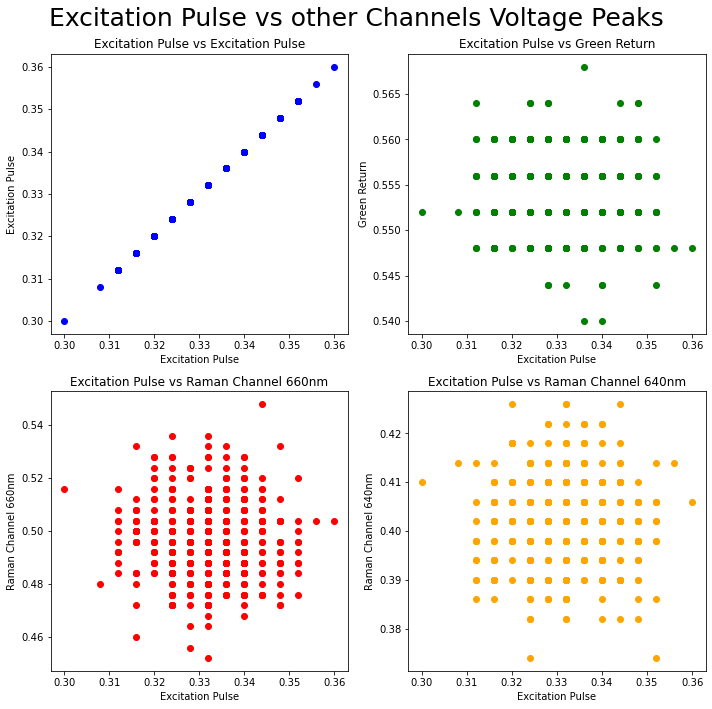

In [25]:
#Channel 1 vs other Channels Voltage Peaks
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax1.scatter(localMaxVoltage_ExcitationPulse,localMaxVoltage_ExcitationPulse, c='blue')
ax1.set_title('Excitation Pulse vs Excitation Pulse')
ax1.set(xlabel = 'Excitation Pulse', ylabel = 'Excitation Pulse')

ax2.scatter(localMaxVoltage_ExcitationPulse,localMaxVoltage_greenReturn, c='green')
ax2.set_title('Excitation Pulse vs Green Return')
ax2.set(xlabel = 'Excitation Pulse', ylabel = 'Green Return')

ax3.scatter(localMaxVoltage_ExcitationPulse,localMaxVoltage_ramanChannel660nm, c='red')
ax3.set_title('Excitation Pulse vs Raman Channel 660nm')
ax3.set(xlabel = 'Excitation Pulse', ylabel = 'Raman Channel 660nm')

ax4.scatter(localMaxVoltage_ExcitationPulse,localMaxVoltage_ramanChannel640nm, c='orange')
ax4.set_title('Excitation Pulse vs Raman Channel 640nm')
ax4.set(xlabel = 'Excitation Pulse', ylabel = 'Raman Channel 640nm')

fig.suptitle('Excitation Pulse vs other Channels Voltage Peaks', fontsize=25)
plt.tight_layout()
plt.show()

Thinking a little further into this mess, perhaps many of the points are in a linear line (overlapping) and the cloud shape is only given due to small uncertainties in measurements. It is possible as there are much less than 512 datapoints on all the graphs (especially the Excitation Pulse vs Excitation Pulse).

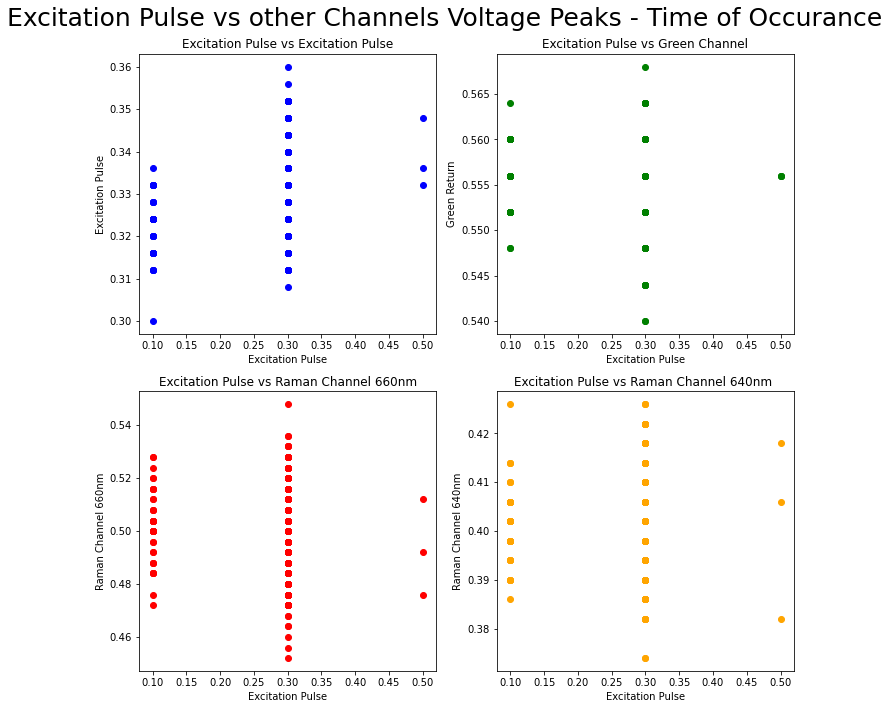

In [26]:
#Channel 1 vs other Channels Voltage Peaks - Time of Occurance
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax1.scatter(localMaxVoltageTime_ExcitationPulse,localMaxVoltage_ExcitationPulse, c='blue')
ax1.set_title('Excitation Pulse vs Excitation Pulse')
ax1.set(xlabel = 'Excitation Pulse', ylabel = 'Excitation Pulse')

ax2.scatter(localMaxVoltageTime_ExcitationPulse,localMaxVoltage_greenReturn, c='green')
ax2.set_title('Excitation Pulse vs Green Channel')
ax2.set(xlabel = 'Excitation Pulse', ylabel = 'Green Return')

ax3.scatter(localMaxVoltageTime_ExcitationPulse,localMaxVoltage_ramanChannel660nm, c='red')
ax3.set_title('Excitation Pulse vs Raman Channel 660nm')
ax3.set(xlabel = 'Excitation Pulse', ylabel = 'Raman Channel 660nm')

ax4.scatter(localMaxVoltageTime_ExcitationPulse,localMaxVoltage_ramanChannel640nm, c='orange')
ax4.set_title('Excitation Pulse vs Raman Channel 640nm ')
ax4.set(xlabel = 'Excitation Pulse', ylabel = 'Raman Channel 640nm')

fig.suptitle('Excitation Pulse vs other Channels Voltage Peaks - Time of Occurance', fontsize=25)
plt.tight_layout()
plt.show()

Quantisation is normal because its the sampling of the oscilloscope, it samples every $x$ seconds

### Ringing && Sampling plotting

In [27]:
#file path with glob
path = "Tektronix_data/"
all_files = glob.glob(path + "tek0029ALL.csv")

#turn all 512 files into lists
var = [pd.read_csv(filename,index_col=None,header=0,skiprows=17) for filename in all_files]

#concat all lists and turn into 1 big dataframe
dataframe0 = pd.concat(var,axis=0,ignore_index=True)

#renaming the headers (they came as Channel 1,2,3,4 - need to know what they represent)
rename = ['Time','Excitation_Pulse','Raman_Channel_Detection_640nm','Raman_Channel_Detection_660nm','Green_Return_532nm']
dataframe0.columns = rename

#change the data type
DF0 = dataframe0.astype(float)

df0 = DF0.assign(Time = Clean_dataframe['Time']*1e9)

#Setting the Time as the index column
df0.set_index("Time",drop=True,inplace=True)

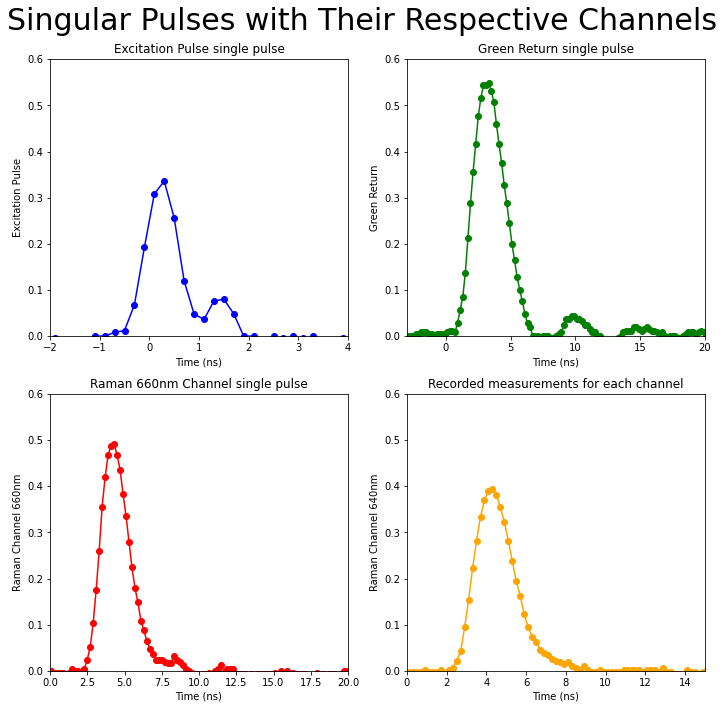

In [28]:
#Plot all columns against Time
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax1.scatter(df0.index,df0.Excitation_Pulse, c='blue')
ax1.plot(df0.index,df0.Excitation_Pulse, c='blue')
ax1.set_title('Excitation Pulse single pulse')
ax1.set(xlabel = 'Time (ns)', ylabel = 'Excitation Pulse',xlim = (-2,4), ylim = (0,0.6))

ax2.scatter(df0.index,df0.Green_Return_532nm, c='green')
ax2.plot(df0.index,df0.Green_Return_532nm, c='green')
ax2.set_title('Green Return single pulse')
ax2.set(xlabel = 'Time (ns)', ylabel = 'Green Return',xlim = (-3,20), ylim = (0,0.6))

ax3.scatter(df0.index,df0.Raman_Channel_Detection_660nm, c='red')
ax3.plot(df0.index,df0.Raman_Channel_Detection_660nm, c='red')
ax3.set_title('Raman 660nm Channel single pulse')
ax3.set(xlabel = 'Time (ns)', ylabel = 'Raman Channel 660nm',xlim = (0,20), ylim = (0,0.6))

ax4.scatter(df0.index,df0.Raman_Channel_Detection_640nm, c='orange')
ax4.plot(df0.index,df0.Raman_Channel_Detection_640nm, c='orange')
ax4.set_title('Raman 640nm Channel single pulse')
ax4.set(xlabel = 'Time (ns)', ylabel = 'Raman Channel 640nm',xlim = (0,15), ylim = (0,0.6))

fig.suptitle('Singular Pulses with Their Respective Channels', fontsize=30)
plt.tight_layout()
plt.title('Recorded measurements for each channel')
plt.show()

In [29]:
#file path with glob
path = "Tektronix_data/"
all_files = glob.glob(path + "tek0404ALL.csv")

#turn all 512 files into lists
var = [pd.read_csv(filename,index_col=None,header=0,skiprows=17) for filename in all_files]

#concat all lists and turn into 1 big dataframe
dataframe1 = pd.concat(var,axis=0,ignore_index=True)

#renaming the headers (they came as Channel 1,2,3,4 - need to know what they represent)
rename = ['Time','Excitation_Pulse','Raman_Channel_Detection_640nm','Raman_Channel_Detection_660nm','Green_Return_532nm']
dataframe1.columns = rename

#change the data type
DF1 = dataframe1.astype(float)

df1 = DF1.assign(Time = Clean_dataframe['Time']*1e9)

#Setting the Time as the index column
df1.set_index("Time",drop=True,inplace=True)

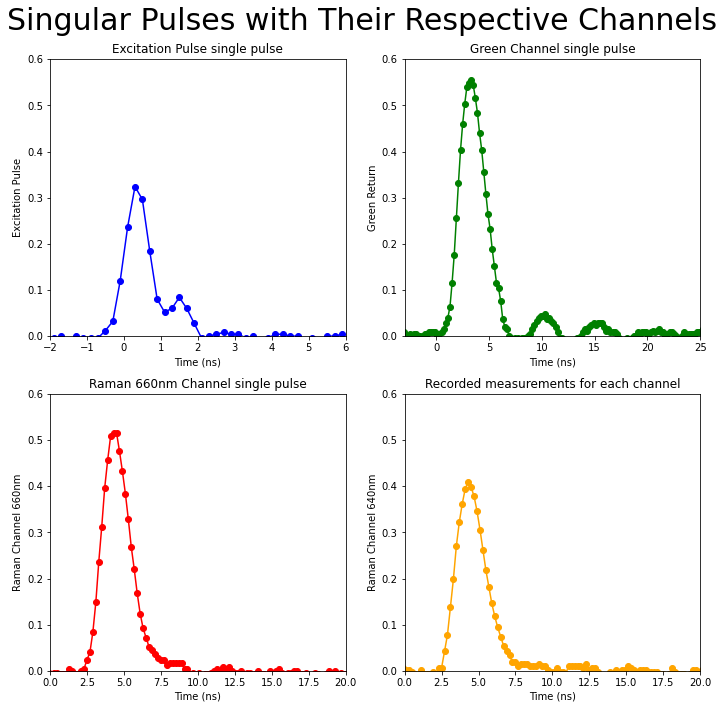

In [30]:
#Plot all columns against Time
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax1.scatter(df1.index,df1.Excitation_Pulse, c='blue')
ax1.plot(df1.index,df1.Excitation_Pulse, c='blue')
ax1.set_title('Excitation Pulse single pulse')
ax1.set(xlabel = 'Time (ns)', ylabel = 'Excitation Pulse',xlim = (-2,6), ylim = (0,0.6))

ax2.scatter(df1.index,df1.Green_Return_532nm, c='green')
ax2.plot(df1.index,df1.Green_Return_532nm, c='green')
ax2.set_title('Green Channel single pulse')
ax2.set(xlabel = 'Time (ns)', ylabel = 'Green Return',xlim = (-3,25), ylim = (0,0.6))

ax3.scatter(df1.index,df1.Raman_Channel_Detection_660nm, c='red')
ax3.plot(df1.index,df1.Raman_Channel_Detection_660nm, c='red')
ax3.set_title('Raman 660nm Channel single pulse')
ax3.set(xlabel = 'Time (ns)', ylabel = 'Raman Channel 660nm',xlim = (0,20), ylim = (0,0.6))

ax4.scatter(df1.index,df1.Raman_Channel_Detection_640nm, c='orange')
ax4.plot(df1.index,df1.Raman_Channel_Detection_640nm, c='orange')
ax4.set_title('Raman 640nm Channel single pulse')
ax4.set(xlabel = 'Time (ns)', ylabel = 'Raman Channel 640nm',xlim = (0,20), ylim = (0,0.6))

fig.suptitle('Singular Pulses with Their Respective Channels', fontsize=30)
plt.tight_layout()
plt.title('Recorded measurements for each channel')
plt.show()

### Averaging 

The averaging on Tektronix that we compare with our calculated data will be the data taken with the lights on, this is because it is unfair to compare the average we calculate to the average taken from Tektronix with the lights off.

In [31]:
#file path with glob
path = "Average_data&traces_Tektronix/"
all_files = glob.glob(path + "average_data_light.csv")

#turn all 512 files into lists
var = [pd.read_csv(filename,index_col=None,header=0,skiprows=17) for filename in all_files]

#concat all lists and turn into 1 big dataframe
dataframe2 = pd.concat(var,axis=0,ignore_index=True)

#renaming the headers (they came as Channel 1,2,3,4 - need to know what they represent)
rename = ['Time','Excitation_Pulse','Raman_Channel_Detection_640nm','Raman_Channel_Detection_660nm','Green_Return_532nm']
dataframe2.columns = rename

#change the data type
DF2 = dataframe2.astype(float)

average_data_with_light = DF2.assign(Time = Clean_dataframe['Time']*1e9)

#Setting the Time as the index column
average_data_with_light.set_index("Time",drop=True,inplace=True)

In [32]:
average_data_with_light.head()

,Excitation_Pulse,Raman_Channel_Detection_640nm,Raman_Channel_Detection_660nm,Green_Return_532nm
Time,,,,
-94.3,-0.006938,-0.007609,-0.008703,0.000969
-94.1,-0.007047,-0.007469,-0.008812,0.000922
-93.9,-0.006844,-0.007734,-0.008797,0.001203
-93.7,-0.007000,-0.007281,-0.008719,0.000953
-93.5,-0.007156,-0.007984,-0.008703,0.001016


**Need to compare the values below with our values from before(above)**

In [33]:
#Average data - Tektroix
data = average_data_with_light

C1_max = data.Excitation_Pulse.max()
GC_max = data.Green_Return_532nm.max()
RC660_max = data.Raman_Channel_Detection_660nm.max()
RC640_max = data.Raman_Channel_Detection_640nm.max()

print('The average maximum of Excitation Pulse calculated by Tektronix is = {0} V'.format(C1_max))
print('The average maximum of Green Return calculated by Tektronix is = {0} V'.format(GC_max))
print('The average maximum of Raman Channel 660nm calculated by Tektronix is = {0} V'.format(RC660_max))
print('The average maximum of Raman Channel 640nm calculated by Tektronix is = {0} V'.format(RC640_max))

The average maximum of Excitation Pulse calculated by Tektronix is = 0.355359 V
The average maximum of Green Return calculated by Tektronix is = 0.538672 V
The average maximum of Raman Channel 660nm calculated by Tektronix is = 0.524312 V
The average maximum of Raman Channel 640nm calculated by Tektronix is = 0.405547 V


In [34]:
#Time of Peak averaged by Tektronix
print('The average time of Peak Occurance of Excitation Pulse calculated by Tektronix is = {0} ns'.format(data.Excitation_Pulse.idxmax()))
print('The average time of Peak Occurance of Green Return calculated by Tektronix is = {0} ns'.format(data.Green_Return_532nm.idxmax()))
print('The average time of Peak Occurance of Raman Channel 660nm calculated by Tektronix is = {0} ns'.format(data.Raman_Channel_Detection_660nm.idxmax()))
print('The average time of Peak Occurance of Raman Channel 640nm calculated by Tektronix is = {0} ns'.format(data.Raman_Channel_Detection_640nm.idxmax()))

The average time of Peak Occurance of Excitation Pulse calculated by Tektronix is = 5.7 ns
The average time of Peak Occurance of Green Return calculated by Tektronix is = 8.5 ns
The average time of Peak Occurance of Raman Channel 660nm calculated by Tektronix is = 9.7 ns
The average time of Peak Occurance of Raman Channel 640nm calculated by Tektronix is = 9.7 ns


In [35]:
#Time of Peak averaged by Tektronix
print('The average time of Peak Occurance of Excitation Pulse calculated by Tektronix is = {0} ns'.format(data.Excitation_Pulse.idxmax()))
print('The average time of Peak Occurance of Green Return calculated by Tektronix is = {0} ns'.format(data.Green_Return_532nm.idxmax()))
print('The average time of Peak Occurance of Raman Channel 660nm calculated by Tektronix is = {0} ns'.format(data.Raman_Channel_Detection_660nm.idxmax()))
print('The average time of Peak Occurance of Raman Channel 640nm calculated by Tektronix is = {0} ns'.format(data.Raman_Channel_Detection_640nm.idxmax()))

The average time of Peak Occurance of Excitation Pulse calculated by Tektronix is = 5.7 ns
The average time of Peak Occurance of Green Return calculated by Tektronix is = 8.5 ns
The average time of Peak Occurance of Raman Channel 660nm calculated by Tektronix is = 9.7 ns
The average time of Peak Occurance of Raman Channel 640nm calculated by Tektronix is = 9.7 ns


In [36]:
#FWHM averaged by Tektronix
print('The average FWHM of Excitation Pulse calculated by Tektronix is = {0} ns'.format(FWHM_time_duration(data.index,data.Excitation_Pulse)))
print('The average FWHM of Green Return calculated by Tektronix is = {0} ns'.format(FWHM_time_duration(data.index,data.Green_Return_532nm)))
print('The average FWHM of Raman Channel 660nm calculated by Tektronix is = {0} ns'.format(FWHM_time_duration(data.index,data.Raman_Channel_Detection_660nm)))
print('The average FWHM of Raman Channel 640nm calculated by Tektronix is = {0} ns'.format(FWHM_time_duration(data.index,data.Raman_Channel_Detection_640nm)))

The average FWHM of Excitation Pulse calculated by Tektronix is = 0.39999999999999947 ns
The average FWHM of Green Return calculated by Tektronix is = 2.6000000000000005 ns
The average FWHM of Raman Channel 660nm calculated by Tektronix is = 1.799999999999999 ns
The average FWHM of Raman Channel 640nm calculated by Tektronix is = 2.200000000000001 ns


### Tables

Don't forget to talk about the Standard Deviation in terms of proportion to the mean value, some Standard Deviations from the picoscope may seem pretty accurate, but when being compared to the mean value, it is much higher than the ratio of standard deviation to the mean for Tektronix data.

In [37]:
meanPeak = pd.read_excel("Mean and StDev of various channels/Mean&StDev_maxPeak.xlsx")
meanPeak.set_index("Channels",drop=True,inplace=True)

meanPeak.head()

,Mean Peak Tektronix (V),Mean Peak PicoScope (V),Standard Deviation for Tektronix (V),Standard Deviation for PicoScope (V),Error Tektronix (%),Error PicoScope (%)
Channels,,,,,,
Excitation Pulse,0.331,0.290,0.009,0.038,2.719033,13.103448
Green Return,0.554,0.025,0.004,0.002,0.722022,8.000000
Raman Channel 660nm,0.496,0.021,0.014,0.003,2.822581,14.285714
Raman Channel 640nm,0.402,0.027,0.008,0.003,1.990050,11.111111


For the average maximum peak, the Oscilloscope is consistently more accurate by an order of magnitude.

In [38]:
timeOfMeanPeak = pd.read_excel("Mean and StDev of various channels/Mean&StDev_timeOfmaxPeak.xlsx")
timeOfMeanPeak.set_index("Channels",drop=True,inplace=True)

timeOfMeanPeak.head()

,Mean Peak Tektronix (ns),Mean Peak PicoScope (ns),Standard Deviation for Tektronix (ns),Standard Deviation for PicoScope (ns),Error Tektronix (%),Error PicoScope (%)
Channels,,,,,,
Excitation Pulse,0.285,1.053,0.056,0.198,19.649123,18.803419
Green Return,3.140,13.098,0.107,0.168,3.407643,1.282639
Raman Channel 660nm,4.247,13.575,0.097,2.866,2.283965,21.112339
Raman Channel 640nm,4.286,10.636,0.100,0.146,2.333178,1.372697


In [39]:
dataFWHM = pd.read_excel("Mean and StDev of various channels/Mean&StDev_FWHM.xlsx")
dataFWHM.set_index("Channels",drop=True,inplace=True)

dataFWHM.head()

,Mean FWHM Tektronix (ns),Mean FWHM PicoScope (ns),Standard Deviation for FWHM Tektronix (ns),Standard Deviation for FWHM PicoScope (ns),Error Tektronix (%),Error PicoScope (%)
Channels,,,,,,
Excitation Pulse,0.535,1.232,0.093,0.179,17.383178,14.529221
Green Return,2.693,2.389,0.099,1.580,3.676198,66.136459
Raman Channel 660nm,1.958,31.607,0.087,15.689,4.443309,49.637738
Raman Channel 640nm,2.108,1.290,0.099,0.095,4.696395,7.364341


Uncertainties of 66% and 49% are really high

There are times where the the Error for the Tektronix is higher than the PicoScope, but whenever that happens its only but a very small amount, but there are many times where the Error for the PicoScope is ridiculously high, up to 66%. 